In [ ]:
using Yao, Zygote, YaoPlots, CuYao, YaoExtensions
using LinearAlgebra, Statistics, Random, StatsBase, ArgParse, Distributions
using PyPlot, Printf, BenchmarkTools, MAT, Plots
using Flux: batch, Flux

# import and visualize the data

In [2]:
# import the FashionMNIST data
vars = matread("../dataset/FashionMNIST_1_2_wk.mat")
x_train = vars["x_train"]
y_train = vars["y_train"]
x_test = vars["x_test"]
y_test = vars["y_test"]

num_train = 1000
num_test = 200
x_train = x_train[:,1:num_train]
y_train = y_train[1:num_train,:]
x_test = x_test[:,1:num_test]
y_test = y_test[1:num_test,:];

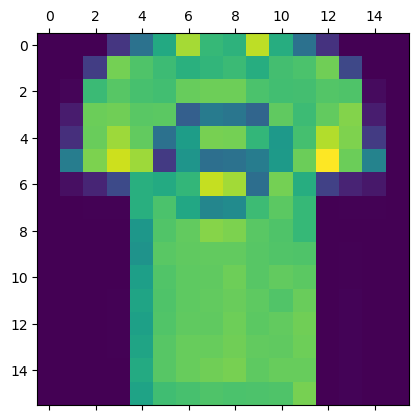

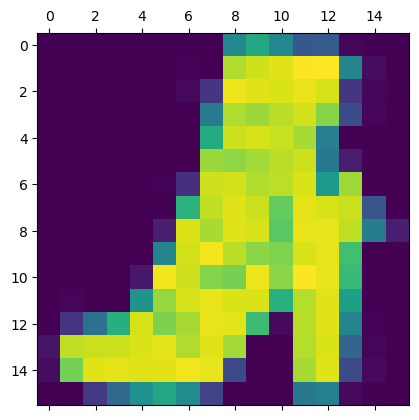

PyObject <matplotlib.image.AxesImage object at 0x7fb96b4195e0>

In [3]:
i = 13
a = real(vars["x_train"][1:256,i])
c = reshape(a,(16,16))
matshow(c) # T-shirt
i = 6
a = real(vars["x_train"][1:256,i])
c = reshape(a,(16,16))
matshow(c) # shoe

# hyper-parameter setting

In [4]:
num_qubit = 8    # number of qubits
depth = 10       # number of parameterized composite_blocks
batch_size = 100 # batch size
lr = 0.01        # learning rate
niters = 30;     # number of iterations
optim = Flux.ADAM(lr); # Adam optimizer

# index of qubit that will be measured
pos_ = 8;       
op0 = put(num_qubit, pos_=>0.5*(I2+Z))
op1 = put(num_qubit, pos_=>0.5*(I2-Z));

# put the training and test set into quantum states

In [5]:
# if GPU resources are available, you can make modifications including 
# replacing  "|> cpu" by "|> cu"
x_train_yao = zero_state(num_qubit,nbatch=num_train)
x_train_yao.state = x_train;
cu_x_train_yao = copy(x_train_yao) |> cpu;

x_test_yao = zero_state(num_qubit,nbatch=num_test)
x_test_yao.state  = x_test;
cu_x_test_yao = copy(x_test_yao) |> cpu;

# define the circuit

In [6]:
# define the QNN circuit, some functions have been defined before
include("../library/Layer.jl")
Ent_Layer(nbit::Int64) = Ent_CX(nbit)
Parameterized_Layer(nbit::Int64) = Params_Layer(nbit)
Composite_Block(nbit::Int64) = chain(nbit, Parameterized_Layer(nbit::Int64), Ent_Layer(nbit::Int64))
circuit = chain(Composite_Block(num_qubit) for _ in 1:depth)
# assign random initial parameters to the circuit
dispatch!(circuit, :random)
params = parameters(circuit);
# YaoPlots.plot(circuit) # for a long circuit, the plot will cost much time

# training

In [7]:
include("../library/Loss_Accuracy.jl")

# record the training history
loss_train_history = Float64[]
acc_train_history = Float64[]
loss_test_history = Float64[]
acc_test_history = Float64[];

In [8]:
for k in 0:niters
    # calculate the accuracy & loss for the training & test set
    train_acc, train_loss = acc_loss_rdm_cu(circuit,cu_x_train_yao,y_train,num_train)
    test_acc, test_loss = acc_loss_rdm_cu(circuit,cu_x_test_yao,y_test,num_test)
    push!(loss_train_history, train_loss)
    push!(loss_test_history, test_loss)
    push!(acc_train_history, train_acc)
    push!(acc_test_history, test_acc)
    if k % 1 == 0
        @printf("\nStep=%d, loss=%.3f, acc=%.3f, test_loss=%.3f,test_acc=%.3f\n",k,train_loss,train_acc,test_loss,test_acc)
    end
    
    # at each training epoch, randomly choose a batch of samples from the training set
    batch_index = randperm(size(x_train)[2])[1:batch_size]
    x_batch = x_train[:,batch_index]
    y_batch = y_train[batch_index,:];
    # prepare these samples into quantum states
    x_batch_1 = copy(x_batch)
    x_batch_yao = zero_state(num_qubit,nbatch=batch_size)
    x_batch_yao.state = x_batch_1;
    cu_x_batch_yao = copy(x_batch_yao) |> cpu;
    batc = [zero_state(num_qubit) for i in 1:batch_size]
    for i in 1:batch_size
        batc[i].state = x_batch_1[:,i:i]
    end
    
    # for all samples in the batch, repeatly measure their qubits at position pos_ 
    # on the computational basis
    reg_ = focus!(copy(cu_x_batch_yao) |> circuit, (pos_)) |> cpu
    rdm = density_matrix(reg_).state;
    q_ = zeros(batch_size,2);
    for i=1:batch_size
        q_[i,:] = diag(rdm[:,:,i]) |> real
    end
    
    # calculate the gradients w.r.t. the cross-entropy loss function
    Arr = Array{Float64}(zeros(batch_size,nparameters(circuit)))
    for i in 1:batch_size
        Arr[i,:] = expect'(op0, copy(batc[i])=>circuit)[2]
    end
    C = [Arr, -Arr]
    grads = collect(mean([-sum([y_batch[i,j]*((1 ./ q_)[i,j])*batch(C)[i,:,j] for j in 1:2]) for i=1:batch_size]))
    
    # update the parameters
    updates = Flux.Optimise.update!(optim, params, grads);
    dispatch!(circuit, updates) 
end


Step=0, loss=0.683, acc=0.598, test_loss=0.675,test_acc=0.650

Step=1, loss=0.646, acc=0.837, test_loss=0.639,test_acc=0.855

Step=2, loss=0.612, acc=0.909, test_loss=0.606,test_acc=0.920

Step=3, loss=0.583, acc=0.945, test_loss=0.578,test_acc=0.945

Step=4, loss=0.560, acc=0.980, test_loss=0.556,test_acc=0.965

Step=5, loss=0.541, acc=0.985, test_loss=0.539,test_acc=0.975

Step=6, loss=0.525, acc=0.986, test_loss=0.524,test_acc=0.980

Step=7, loss=0.511, acc=0.987, test_loss=0.512,test_acc=0.985

Step=8, loss=0.498, acc=0.988, test_loss=0.499,test_acc=0.985

Step=9, loss=0.486, acc=0.988, test_loss=0.487,test_acc=0.985

Step=10, loss=0.475, acc=0.988, test_loss=0.476,test_acc=0.985

Step=11, loss=0.466, acc=0.989, test_loss=0.467,test_acc=0.985

Step=12, loss=0.457, acc=0.989, test_loss=0.458,test_acc=0.985

Step=13, loss=0.450, acc=0.989, test_loss=0.450,test_acc=0.985

Step=14, loss=0.444, acc=0.988, test_loss=0.443,test_acc=0.985

Step=15, loss=0.438, acc=0.989, test_loss=0.437,t

# visualization of the training

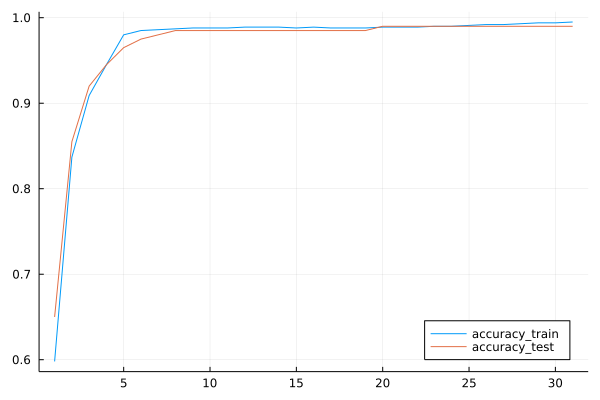

In [9]:
Plots.plot(acc_train_history,label="accuracy_train",legend = :bottomright)
Plots.plot!(acc_test_history,label="accuracy_test",legend = :bottomright)
# Plots.savefig("acc.pdf")

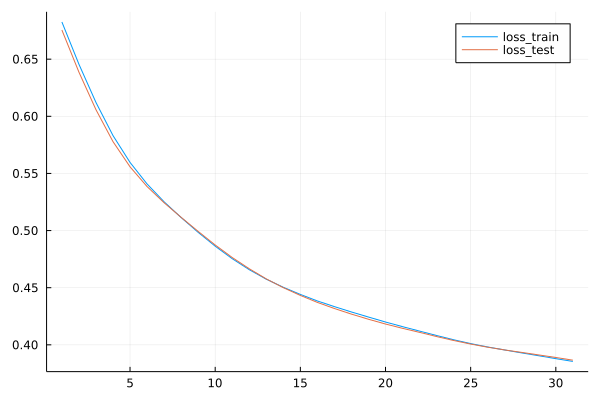

In [10]:
Plots.plot(loss_train_history,label="loss_train")
Plots.plot!(loss_test_history,label="loss_test")
# Plots.savefig("loss.pdf")

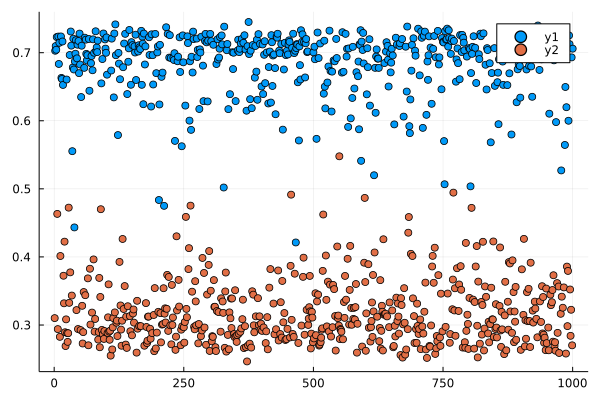

In [11]:
reg_ = focus!(copy(cu_x_train_yao) |> circuit, (pos_)) |> cpu
rdm = density_matrix(reg_).state;
q_ = zeros(num_train,2);
for i=1:num_train
    q_[i,:] = diag(rdm[:,:,i]) |> real
end
class1x = Int64[]
class2x = Int64[]
class1y = Float64[]
class2y = Float64[]
for i in 1:num_train
    if y_train[i,1] == 1.0
        push!(class1x,i)
        push!(class1y,q_[i,1])
    else
        push!(class2x,i)
        push!(class2y,q_[i,1])
    end
end
# predicted value (expectation value)
# lower loss leads to larger separation between the two classes of data points
Plots.plot(class1x, class1y, seriestype = :scatter)
Plots.plot!(class2x, class2y, seriestype = :scatter)